目标是拟合这样一个多项式：$y = 1.2x - 3.4x^2 + 5.6x^3 + 5 + \epsilon,$

如果只输入x，那么用Linear无法拟合出y，但是如果构造出x, x^2, x^3，那么Linear就可以拟合。

此外，如果用深层网络，加激活函数，也可以拟合，但是需要调整很多参数（学习率，网络结构，迭代轮数）

In [14]:
import torch
from torch import nn
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt


torch.manual_seed(1)

np.set_printoptions(suppress=True)

print(torch.__version__)
torch.set_default_tensor_type('torch.FloatTensor')

1.4.0


In [0]:
n_train, n_test, true_w, true_b = 100, 100, [1.2, -3.4, 5.6], 5
features = torch.randn((n_train + n_test, 1))

In [9]:
features.shape

torch.Size([200, 1])

In [10]:
poly_features = torch.cat((features, torch.pow(features, 2), torch.pow(features, 3)), 1) 
poly_features.shape

torch.Size([200, 3])

In [11]:
labels = (true_w[0] * poly_features[:, 0] + true_w[1] * poly_features[:, 1]
          + true_w[2] * poly_features[:, 2] + true_b)
labels.shape

torch.Size([200])

In [0]:
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()), dtype=torch.float)


In [0]:
def semilogy(x_vals, y_vals, x_label, y_label, x2_vals=None, y2_vals=None,
             legend=None, figsize=(3.5, 2.5)):
    plt.rcParams['figure.figsize'] = figsize
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.semilogy(x_vals, y_vals)
    if x2_vals and y2_vals:
        plt.semilogy(x2_vals, y2_vals, linestyle=':')
        plt.legend(legend)

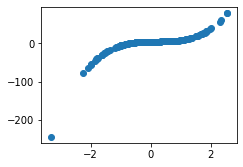

In [30]:
x = features.numpy().ravel()
y = labels.numpy().ravel()
plt.scatter(x,y)

In [0]:
num_epochs, loss = 100, torch.nn.MSELoss()

def fit_and_plot(train_features, test_features, train_labels, test_labels):
    net = torch.nn.Linear(train_features.shape[-1],1)
    batch_size = min(10,train_labels.shape[0])
    dataset = torch.utils.data.TensorDataset(train_features, train_labels)
    train_iter = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    optimizer = torch.optim.SGD(net.parameters(), lr=0.01)
    train_ls, test_ls = [], []

    for _ in range(num_epochs):
        for X, y in train_iter:
            l = loss(net(X), y.view(-1,1))
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
        train_labels = train_labels.view(-1,1)
        test_labels = test_labels.view(-1,1)
        train_ls.append(loss(net(train_features), train_labels).item())
        test_ls.append(loss(net(test_features), test_labels).item())

    print('final epoch: train loss', train_ls[-1], 'test loss', test_ls[-1])
    semilogy(range(1,num_epochs+1), train_ls, 'epochs', 'loss', range(1,num_epochs+1), test_ls, ['train', 'test'])

final epoch: train loss 0.00010774884140118957 test loss 0.00012866879114881158


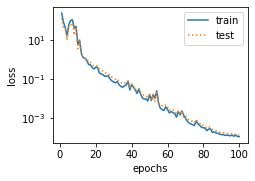

In [27]:
fit_and_plot(poly_features[:n_train,:], poly_features[n_train:,:], labels[:n_train], labels[n_train:])

final epoch: train loss 419.89215087890625 test loss 135.51666259765625


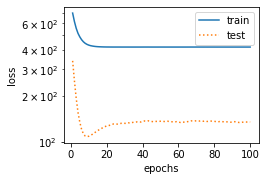

In [31]:
fit_and_plot(features[:n_train, :], features[n_train:, :], labels[:n_train],
             labels[n_train:])

final epoch: train loss 3.022223711013794 test loss 16.580829620361328


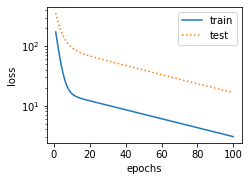

In [32]:
fit_and_plot(poly_features[0:2, :], poly_features[n_train:, :], labels[0:2],
             labels[n_train:])

In [37]:
num_inputs

1

In [0]:
def fit_and_plot_deep(train_features, test_features, train_labels, test_labels, lr=0.001):
    num_inputs = features.shape[-1]
    net = nn.Sequential(
        nn.Flatten(),
        nn.Linear(num_inputs, 32),
        nn.ReLU(),
        nn.Linear(32, 10),
        nn.ReLU(),
        nn.Linear(10, 10),
        nn.ReLU(),
        nn.Linear(10, 1),
    )

    batch_size = min(10,train_labels.shape[0])
    dataset = torch.utils.data.TensorDataset(train_features, train_labels)
    train_iter = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    train_ls, test_ls = [], []

    for _ in range(num_epochs):
        for X, y in train_iter:
            l = loss(net(X), y.view(-1,1))
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
        train_labels = train_labels.view(-1,1)
        test_labels = test_labels.view(-1,1)
        train_ls.append(loss(net(train_features), train_labels).item())
        test_ls.append(loss(net(test_features), test_labels).item())

    print('final epoch: train loss', train_ls[-1], 'test loss', test_ls[-1])
    semilogy(range(1,num_epochs+1), train_ls, 'epochs', 'loss', range(1,num_epochs+1), test_ls, ['train', 'test'])

final epoch: train loss 0.1998102068901062 test loss 1.2132312059402466


11

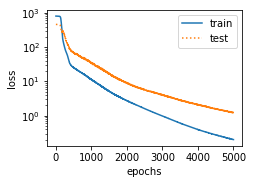

In [56]:
num_epochs = 5000
fit_and_plot_deep(features[:n_train, :], features[n_train:, :], labels[:n_train],
             labels[n_train:], 5e-5)
32-10-10-1

final epoch: train loss 3.152116298675537 test loss 17.033199310302734


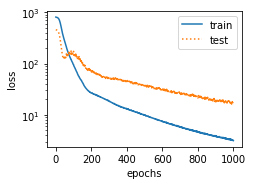

In [51]:
64-32

final epoch: train loss 1.9361751079559326 test loss 11.52282428741455


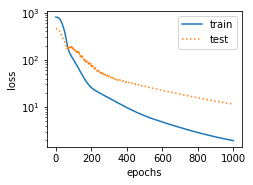

In [49]:
32-16

final epoch: train loss 19.506519317626953 test loss 56.782318115234375


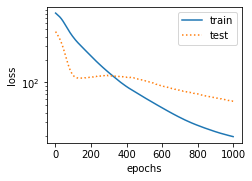